# Fake News Detector

### 1. Introduction & Goal

A lot of people get misguided by "fake news" online and it poses a significant challenge to active engagement online. This project aims to develop a machine learning model capable of classifying news articles as either **Real** or **Fake** based on their content.

We will use Natural Language Processing (NLP) techniques to analyze the text of news headlines and articles. The primary goal is to build a robust classifier that achieves high accuracy and to understand which features (headlines vs. full text) are most predictive.

We will build and evaluate two primary models:
*   **Model v1:** A baseline model using only the article **headlines**.
*   **Model v2:** An enhanced model using both the **headlines and the full article text**.

The final enhanced model (`v2`) achieved an accuracy of **99.21%** on the held-out test data. (which to be honest feels too ideal)

### 2. The Dataset

The data for this project is provided in two separate CSV files: `True.csv` and `Fake.csv` from [Kaggle](https://www.kaggle.com/datasets/razanaqvi14/real-and-fake-news/data).

**Original Features:**
*   `title`: The headline of the news article.
*   `text`: The full body of the article.
*   `subject`: Thematic category (e.g., politics, worldnews).
*   `date`: The publication date.

**Key Data Cleaning Step:**
During Exploratory Data Analysis (EDA), we discovered a critical **data leak** in the `subject` column. The subjects for real and fake news had no overlap, meaning this feature would act as a "cheat sheet" for the model. To ensure the model learns from the text itself, both the `subject` and `date` columns were dropped.

### 3. Project Workflow

This notebook follows a structured machine learning workflow:

1.  **Data Ingestion & Combination:** Loading the two datasets, adding a `label` (0 for Real, 1 for Fake), and combining them into a single, shuffled DataFrame.
2.  **Exploratory Data Analysis (EDA):** Investigating the data for missing values, class balance, and potential data leaks.
3.  **Text Pre-processing:** Using **SpaCy** to clean and normalize the text data by converting it to lowercase, lemmatizing words, and removing stop words and punctuation.
4.  **Feature Engineering:** Converting the cleaned text into numerical vectors using the **TF-IDF (Term Frequency-Inverse Document Frequency)** method.
5.  **Model Training:** Building and training `Logistic Regression` classifiers on the engineered features.
6.  **Model Evaluation:** Assessing model performance using metrics like accuracy, precision, recall, and the confusion matrix.
7.  **Interactive Prediction:** Creating a function to test the final model with new, unseen article text.

### 4. Key Technologies Used

*   **Core Libraries:** Pandas, Scikit-learn, SpaCy, Matplotlib, Seaborn


In [2]:
import pandas as pd
import numpy as np
import statistics
import time
import spacy
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set_style("darkgrid")

In [3]:
true_data = pd.read_csv("True.csv")
true_data

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [4]:
false_data = pd.read_csv("Fake.csv")
false_data

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


# Data Cleaning and Normalization

In [5]:
true_data['label'] = 0
false_data['label'] = 1

data = pd.concat([true_data, false_data], ignore_index=True)

data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1
...,...,...,...,...,...
44893,Nigeria says U.S. agrees delayed $593 million ...,ABUJA (Reuters) - The United States has formal...,worldnews,"December 27, 2017",0
44894,Boiler Room #62 – Fatal Illusions,Tune in to the Alternate Current Radio Network...,Middle-east,"June 29, 2016",1
44895,ATHEISTS SUE GOVERNOR OF TEXAS Over Display on...,I m convinced the Freedom From Religion group...,Government News,"Feb 27, 2016",1
44896,Republican tax plan would deal financial hit t...,WASHINGTON (Reuters) - The Republican tax plan...,politicsNews,"November 2, 2017",0


In [6]:


# data.iloc[2107]

# data = data[~data['date'].str.contains('https://', na=False)]

data["date"] = pd.to_datetime(data["date"], format="mixed", errors='coerce')

In [7]:
data = data[~data["date"].isna()]

Found all non date values in the date column and dropped them

In [8]:
false_data["subject"].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

In [9]:
data = data.drop(columns=["subject", "date"])

<Axes: xlabel='label', ylabel='count'>

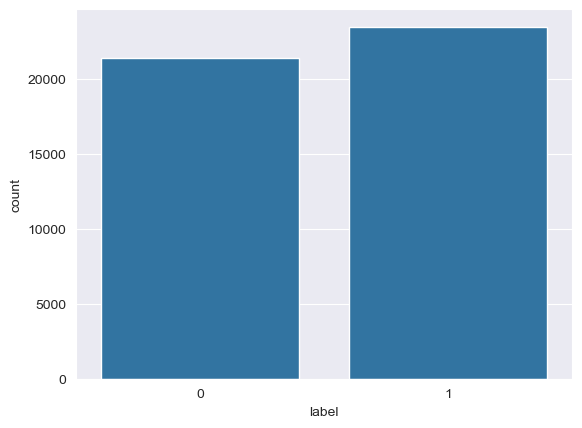

In [10]:
sns.countplot(x="label", data=data)

In [11]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [12]:
f"Punctuation to remove: {string.punctuation}"

'Punctuation to remove: !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
def preprocess_text(text):
    """
    Takes a text string and returns a list of cleaned, lemmatized tokens.
    """
    # Process the text with SpaCy
    doc = nlp(text)
    
    # Lemmatize, lowercase, and remove stop words and punctuation
    cleaned_tokens = []
    for token in doc:
        # Check if the token is not a stop word and not punctuation
        if not token.is_stop and not token.is_punct:
            # Lemmatize and convert to lower case
            lemma = token.lemma_.lower().strip()
            cleaned_tokens.append(lemma)
            
    # Join the tokens back into a single string, separated by spaces
    return " ".join(cleaned_tokens)

In [14]:
# def preprocess_text(series):
#     """
#     Takes a text string and returns a list of cleaned, lemmatized tokens.
#     """

#     for i in series:
        
#         doc = nlp(i)
        
#         cleaned_tokens = []

#         for token in doc:
#             if not token.is_stop and not token.is_punct:
#                 lemma = token.lemma_.lower().strip()
#                 cleaned_tokens.append(lemma)
                
        
#         yield " ".join(cleaned_tokens)
        

In [15]:
data['processed_title'] = data['title'].apply(preprocess_text)

In [16]:
# data['processed_title'] = pd.Series(list(preprocess_text(data['title'])), name='proc_title')

# Tier One Model 

- **Goal:** Build a strong, simple, and interpretable baseline model.
- **Features:** TF-IDF from the title only.
- **Why?** This gives us a benchmark score. If this simple model already gets 95% accuracy, we know that adding more features will only give us marginal gains. It's fast and lets us build the end-to-end pipeline correctly.

In [17]:
X = data["processed_title"]
y = data["label"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# --- Initialize and fit the TF-IDF Vectorizer ---
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [20]:
# --- Verification ---
print("Shape of the TF-IDF training matrix:", X_train_tfidf.shape)
print("Shape of the TF-IDF testing matrix:", X_test_tfidf.shape)

Shape of the TF-IDF training matrix: (35910, 5000)
Shape of the TF-IDF testing matrix: (8978, 5000)


### Training

In [21]:
base_model = LogisticRegression(random_state=42)
base_model.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=42)

In [22]:
y_pred = base_model.predict(X_test_tfidf)

In [23]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 94.25%


In [24]:
# --- 4. Display the Classification Report ---
# This report gives us precision, recall, and f1-score for each class.
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real (0)', 'Fake (1)']))


Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.93      0.95      0.94      4284
    Fake (1)       0.95      0.93      0.94      4694

    accuracy                           0.94      8978
   macro avg       0.94      0.94      0.94      8978
weighted avg       0.94      0.94      0.94      8978



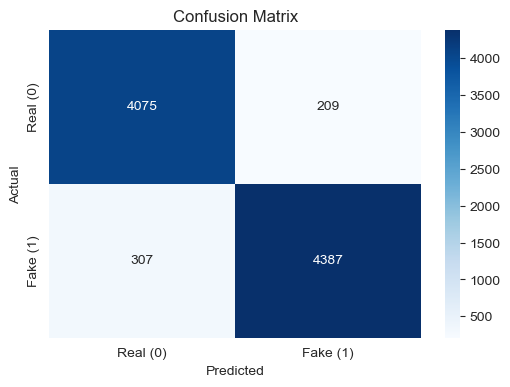

In [25]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real (0)', 'Fake (1)'], 
            yticklabels=['Real (0)', 'Fake (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
def predict_headline(headline_text, model, vectorizer):
    """
    Takes a raw headline string, processes it, and predicts if it's real or fake.
    """
    # 1. Pre-process the input text
    processed_text = preprocess_text(headline_text)
    
    # 2. Vectorize the processed text using the FITTED vectorizer
    # Note: vectorizer.transform expects an iterable (like a list), so we pass [processed_text]
    text_vector = vectorizer.transform([processed_text])
    
    # 3. Make a prediction
    prediction = model.predict(text_vector)
    
    # 4. Get the prediction probability
    # model.predict_proba returns probabilities for both classes [P(real), P(fake)]
    prediction_proba = model.predict_proba(text_vector)
    
    # 5. Interpret the results
    if prediction[0] == 0:
        label = "This looks like a REAL news headline."
        confidence = prediction_proba[0][0]
    else:
        label = "This looks like a FAKE news headline."
        confidence = prediction_proba[0][1]
        
    print(label)
    print(f"Confidence: {confidence * 100:.2f}%")

In [27]:
predict_headline("Women kidnapped by obsessive parents who wish to control their dogs", base_model, vectorizer)

This looks like a FAKE news headline.
Confidence: 55.95%


# Tier Two Model


- **Goal:** Enhance the model with more text and simple metadata features.
- **New Features:**
- TF-IDF from the text column (combined with title TF-IDF).
- Sentiment Scores (from title and text).
- Readability Scores (from text).
- Clickbait keywords (from title).
- **Why?** These are the highest-impact and easiest-to-implement features from your list. 

In [28]:
data_two = data[~data["text"].str.strip().eq("")]

In [29]:
def preprocess_text_improved(texts, chunk_size=2000, batch_size=500):
    """
    Takes a list of text strings and returns a list of cleaned, lemmatized tokens.
    Optimized for batch processing with progress tracking and chunked processing.
    """
    all_processed_texts = []
    
    # Process texts in chunks
    for i in tqdm(range(0, len(texts), chunk_size), desc="Processing chunks"):
        chunk = texts[i:i+chunk_size]
        chunk_processed = []
        
        # Process current chunk with progress bar
        with tqdm(total=len(chunk), desc=f"Chunk {i//chunk_size + 1}", leave=False) as pbar:
            # Process texts in batches using SpaCy's pipe for efficiency
            for doc in nlp.pipe(chunk, batch_size=batch_size):
                # Lemmatize, lowercase, and remove stop words and punctuation
                cleaned_tokens = []
                for token in doc:
                    # Check if the token is not a stop word and not punctuation
                    if not token.is_stop and not token.is_punct:
                        # Lemmatize and convert to lower case
                        lemma = token.lemma_.lower().strip()
                        if lemma:  # Only add non-empty tokens
                            cleaned_tokens.append(lemma)
                
                # Join the tokens back into a single string, separated by spaces
                chunk_processed.append(" ".join(cleaned_tokens))
                pbar.update(1)
        
        all_processed_texts.extend(chunk_processed)
        print(f"Completed {min(i+chunk_size, len(texts))}/{len(texts)} texts")
    
    return all_processed_texts

In [30]:
print("Starting text preprocessing...")
data_two["processed_text"] = preprocess_text_improved(data_two["text"].tolist())
print("Preprocessing complete!")

Starting text preprocessing...


Processing chunks:   4%|▍         | 1/23 [02:09<47:27, 129.45s/it]

Completed 2000/44257 texts


Processing chunks:   9%|▊         | 2/23 [03:52<39:49, 113.79s/it]

Completed 4000/44257 texts


Processing chunks:  13%|█▎        | 3/23 [05:43<37:31, 112.55s/it]

Completed 6000/44257 texts


Processing chunks:  17%|█▋        | 4/23 [07:53<37:53, 119.64s/it]

Completed 8000/44257 texts


Processing chunks:  22%|██▏       | 5/23 [09:42<34:45, 115.84s/it]

Completed 10000/44257 texts


Processing chunks:  26%|██▌       | 6/23 [11:40<33:01, 116.55s/it]

Completed 12000/44257 texts


Processing chunks:  30%|███       | 7/23 [14:00<33:07, 124.22s/it]

Completed 14000/44257 texts


Processing chunks:  35%|███▍      | 8/23 [16:02<30:51, 123.46s/it]

Completed 16000/44257 texts


Processing chunks:  39%|███▉      | 9/23 [17:51<27:44, 118.91s/it]

Completed 18000/44257 texts


Processing chunks:  43%|████▎     | 10/23 [20:38<28:57, 133.62s/it]

Completed 20000/44257 texts


Processing chunks:  48%|████▊     | 11/23 [24:03<31:05, 155.43s/it]

Completed 22000/44257 texts


Processing chunks:  52%|█████▏    | 12/23 [26:39<28:34, 155.85s/it]

Completed 24000/44257 texts


Processing chunks:  57%|█████▋    | 13/23 [29:10<25:42, 154.29s/it]

Completed 26000/44257 texts


Processing chunks:  61%|██████    | 14/23 [30:47<20:33, 137.02s/it]

Completed 28000/44257 texts


Processing chunks:  65%|██████▌   | 15/23 [32:21<16:31, 123.91s/it]

Completed 30000/44257 texts


Processing chunks:  70%|██████▉   | 16/23 [33:44<13:00, 111.56s/it]

Completed 32000/44257 texts


Processing chunks:  74%|███████▍  | 17/23 [34:58<10:01, 100.23s/it]

Completed 34000/44257 texts


Processing chunks:  78%|███████▊  | 18/23 [36:51<08:41, 104.22s/it]

Completed 36000/44257 texts


Processing chunks:  83%|████████▎ | 19/23 [38:27<06:46, 101.60s/it]

Completed 38000/44257 texts


Processing chunks:  87%|████████▋ | 20/23 [39:34<04:33, 91.33s/it] 

Completed 40000/44257 texts


Processing chunks:  91%|█████████▏| 21/23 [40:42<02:48, 84.25s/it]

Completed 42000/44257 texts


Processing chunks:  96%|█████████▌| 22/23 [41:56<01:21, 81.33s/it]

Completed 44000/44257 texts


Processing chunks: 100%|██████████| 23/23 [42:10<00:00, 110.00s/it]


Completed 44257/44257 texts
Preprocessing complete!


C:\Users\Kamiye\AppData\Local\Temp\ipykernel_44040\2385197916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_two["processed_text"] = preprocess_text_improved(data_two["text"].tolist())


In [31]:
X_title = data_two['processed_title']
X_text = data_two['processed_text']
y = data_two['label'] 

In [32]:
X_train_title, X_test_title, y_train, y_test = train_test_split(X_title, y, test_size=0.2, random_state=42, stratify=y)
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Fit TWO separate TF-IDF Vectorizers 
# Vectorizer for titles

title_vectorizer = TfidfVectorizer(max_features=3000)
X_train_title_tfidf = title_vectorizer.fit_transform(X_train_title)
X_test_title_tfidf = title_vectorizer.transform(X_test_title)
print(f"Title TF-IDF matrix shape: {X_train_title_tfidf.shape}")

# Vectorizer for text
# We can use more features for the text since it's richer
text_vectorizer = TfidfVectorizer(max_features=7000)
X_train_text_tfidf = text_vectorizer.fit_transform(X_train_text)
X_test_text_tfidf = text_vectorizer.transform(X_test_text)
print(f"Text TF-IDF matrix shape: {X_train_text_tfidf.shape}")

Title TF-IDF matrix shape: (35405, 3000)
Text TF-IDF matrix shape: (35405, 7000)


In [34]:
# --- Combine the training matrices ---
# hstack stands for "horizontal stack". It places the matrices side-by-side.
X_train_full = hstack([X_train_title_tfidf, X_train_text_tfidf])

X_test_full = hstack([X_test_title_tfidf, X_test_text_tfidf])

In [ ]:
# -- Verification ---
print("Shape of the combined training matrix:", X_train_full.shape)
print("Shape of the combined testing matrix:", X_test_full.shape)

Shape of the combined training matrix: (35405, 10000)
Shape of the combined testing matrix: (8852, 10000)


In [36]:
model_v2 = LogisticRegression(random_state=42)

model_v2.fit(X_train_full, y_train)

LogisticRegression(random_state=42)

In [ ]:
# -- Calculate and display results ---

y_pred_v2 = model_v2.predict(X_test_full)
accuracy_v2 = accuracy_score(y_test, y_pred_v2)
print(f"\nNew Model (v2) Accuracy: {accuracy_v2 * 100:.2f}%")


New Model (v2) Accuracy: 99.20%


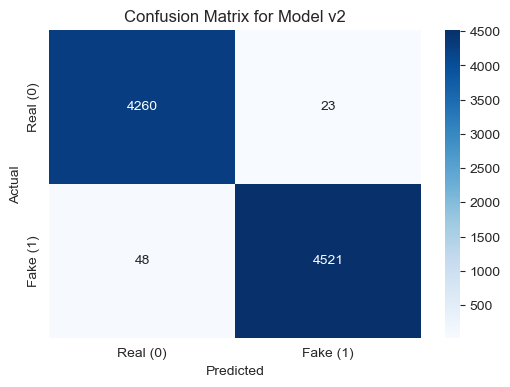

In [38]:
cm_v2 = confusion_matrix(y_test, y_pred_v2)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_v2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real (0)', 'Fake (1)'], 
            yticklabels=['Real (0)', 'Fake (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Model v2')
plt.show()

In [39]:
print("\nNew Model (v2) Classification Report:")
print(classification_report(y_test, y_pred_v2, target_names=['Real (0)', 'Fake (1)']))


New Model (v2) Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.99      0.99      0.99      4283
    Fake (1)       0.99      0.99      0.99      4569

    accuracy                           0.99      8852
   macro avg       0.99      0.99      0.99      8852
weighted avg       0.99      0.99      0.99      8852



In [ ]:
def predict_full_article(title, text):
    """
    Takes a raw title and article text, processes them, 
    and predicts if the article is real or fake using the v2 model.
    """
    # 1. Pre-process both inputs
    processed_title = preprocess_text(title)
    processed_text = preprocess_text(text)
    
    # 2. Vectorize each part using the corresponding FITTED vectorizer
    title_vec = title_vectorizer.transform([processed_title])
    text_vec = text_vectorizer.transform([processed_text])
    
    # 3. Combine the vectors
    full_vec = hstack([title_vec, text_vec])
    
    # 4. Make a prediction
    prediction = model_v2.predict(full_vec)
    
    # 5. Get the prediction probability
    prediction_proba = model_v2.predict_proba(full_vec)
    
    # 6. Interpret the results
    if prediction[0] == 0:
        label = "This looks like a REAL news article."
        confidence = prediction_proba[0][0]
    else:
        label = "This looks like a FAKE news article."
        confidence = prediction_proba[0][1]
        
    print(f"Prediction: {label}")
    print(f"Confidence: {confidence * 100:.2f}%")

In [ ]:
test_title = "Trump signs 'big, beautiful' bill in sweeping victory for second term agenda, overcoming Dems and GOP rebels"

test_text = """
WASHINGTON (Reuters) - President Donald Trump on Friday signed into law a comprehensive legislative package 
that overhauls the nation's tax code, marking a significant victory for his administration. 
The bill, passed by both the House and Senate earlier this week, delivers substantial tax cuts 
to corporations and individuals. The final vote was largely along party lines, with several 
moderate Republicans joining Democrats in opposition before the measure ultimately passed.
"""

print(f"Testing article:\n- Title: {test_title}\n- Text: {test_text[:100]}...") # Print first 100 chars of text
print("-" * 30)
predict_full_article(test_title, test_text)

Testing article:
- Title: Trump signs 'big, beautiful' bill in sweeping victory for second term agenda, overcoming Dems and GOP rebels
- Text: 
WASHINGTON (Reuters) - President Donald Trump on Friday signed into law a comprehensive legislative...
------------------------------
Prediction: This looks like a REAL news article.
Confidence: 84.37%


In [42]:
n_title = "Mysterious 'Quantum Crystal' Discovered in Arctic Ice, Promises Unlimited Energy"

n_text = "In a groundbreaking discovery that could reshape global energy markets, a team of Norwegian scientists has unearthed a previously unknown crystalline structure deep within the Arctic ice sheets. Dubbed the 'Quantum Crystal' by researchers at the University of Oslo, this luminescent material is said to generate energy through a process that defies conventional physics, potentially offering a limitless, clean power source."

predict_full_article(n_title, n_text)

Prediction: This looks like a FAKE news article.
Confidence: 63.22%
